In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os
from scipy.stats.mstats import winsorize
import seaborn as sns
import sklearn
plt.rcParams["font.sans-serif"]="Times New Roman"

In [9]:
# 读取数据
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names

# 数据预处理


## 缺失值与outlier

In [26]:
# null检验
null_data=pd.DataFrame(pd.isna(train_data).sum(),columns=["Null_num"])
null_data["Null_percentage"]=null_data.Null_num/(train_data.count()+null_data.Null_num)
null_data.Null_percentage=null_data.Null_percentage.apply(lambda x: format(x,".2%"))
null_data

,Null_num,Null_percentage
Default,0,0.00%
Balance_r,0,0.00%
Age,0,0.00%
Worse_1m,0,0.00%
Debt_r,0,0.00%
Income,29731,19.82%
Credit_num,0,0.00%
Worse_3m,0,0.00%
Estate_num,0,0.00%
Worse_2m,0,0.00%


上面的表格展示了数据中null的数量, 总的观察点有150000个, 而null最多的feature有接近30000个null. 占比19.82%. 因此在后面的分析我们需要对缺失值做一定的处理

In [32]:
# 数据特征 summary
train_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Default,150000.0,0.07,0.25,0.0,0.00,0.00,0.00,1.0
Balance_r,150000.0,6.05,249.76,0.0,0.03,0.15,0.56,50708.0
Age,150000.0,52.30,14.77,0.0,41.00,52.00,63.00,109.0
Worse_1m,150000.0,0.42,4.19,0.0,0.00,0.00,0.00,98.0
Debt_r,150000.0,353.01,2037.82,0.0,0.18,0.37,0.87,329664.0
Income,120269.0,6670.22,14384.67,0.0,3400.00,5400.00,8249.00,3008750.0
Credit_num,150000.0,8.45,5.15,0.0,5.00,8.00,11.00,58.0
Worse_3m,150000.0,0.27,4.17,0.0,0.00,0.00,0.00,98.0
Estate_num,150000.0,1.02,1.13,0.0,0.00,1.00,2.00,54.0
Worse_2m,150000.0,0.24,4.16,0.0,0.00,0.00,0.00,98.0


观察各个数据的分位数和最大最小值可以看出, 每个feature都存在着outlier. 画出箱型图来侦测outlier

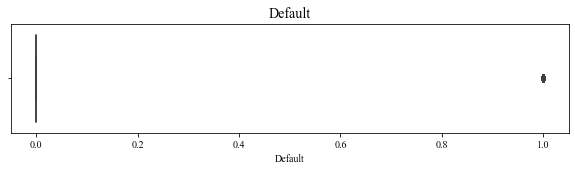

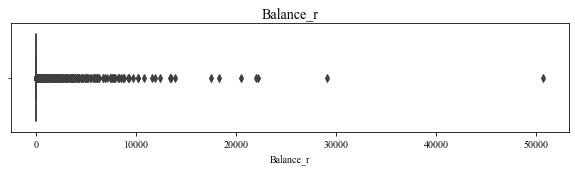

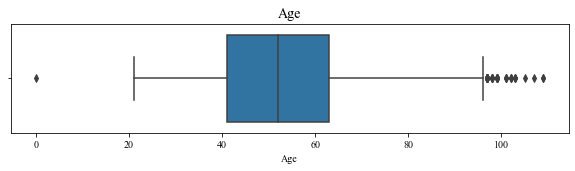

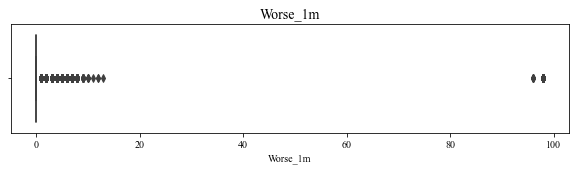

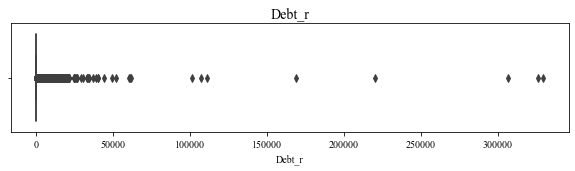

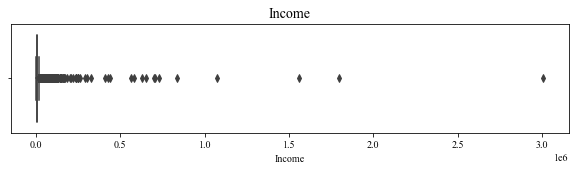

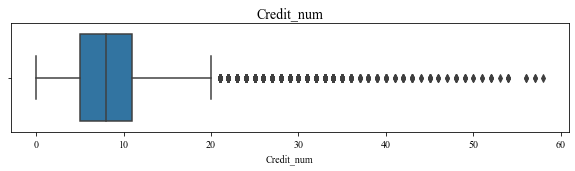

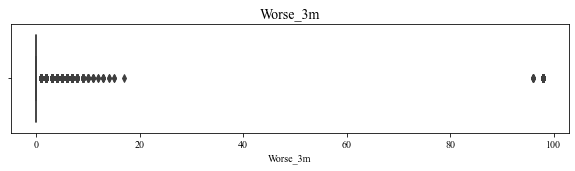

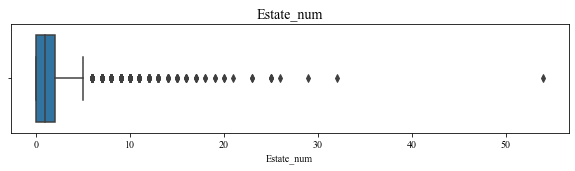

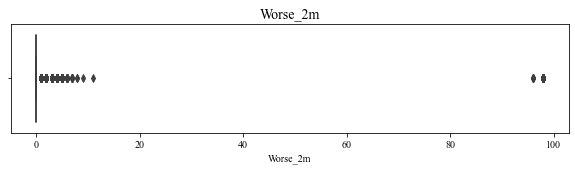

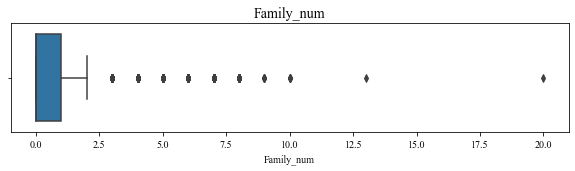

In [44]:
# 箱型图
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)

从箱型图可以侦测出, 部分数据具有极多的outlier, 并且有着相当明显的左偏特征. 为此, 首先计算每个数据的偏度, 对偏度较高的数据做log变换

In [60]:
# 计算偏度
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_df

,skew
Income,114.040318
Balance_r,97.631574
Debt_r,95.157793
Worse_2m,23.331743
Worse_3m,23.087345
Worse_1m,22.597108
Estate_num,3.482484
Default,3.468857
Family_num,1.588242
Credit_num,1.215314


,skew
Balance_r,11.704798
Worse_2m,10.605853
Worse_3m,8.810639
Worse_1m,4.272123
Debt_r,1.749013
Income,-4.364720


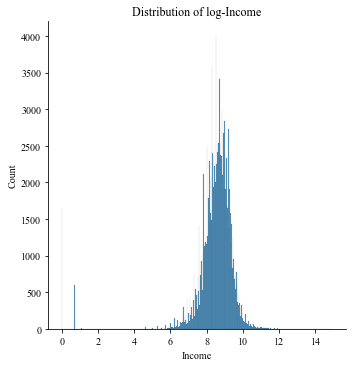

In [65]:
# 将偏度大于10的进行对数变换
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
skew_log =log_data.skew().sort_values(ascending =False )
skew_log=pd.DataFrame({'skew':skew_log})
sns.displot(log_data.Income)
plt.title("Distribution of log-Income", size=12)
skew_log

第一张表格给出了各个数据的偏度, 我们对所有偏度大于10的数据进行对数变换, 并计算对数变换后的偏度. 偏度的数据表明, 对数变换后的分布更加对称(log-Income的图像也验证了这一点). 我们因此, 我们采用对数变换后的数据进行分析

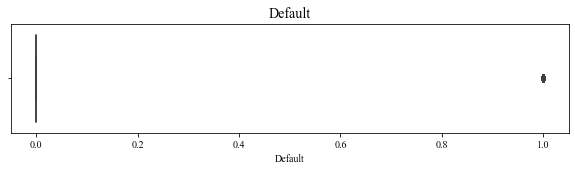

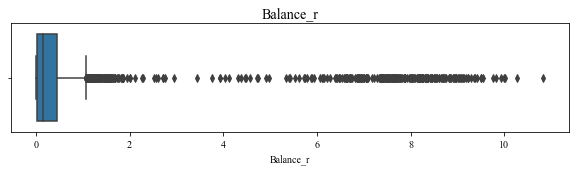

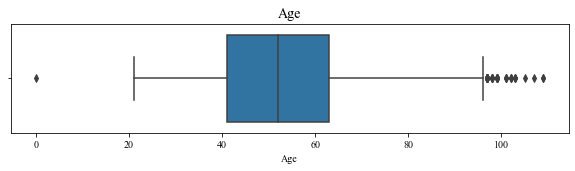

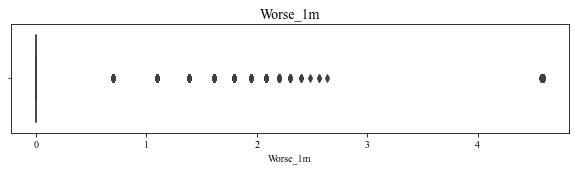

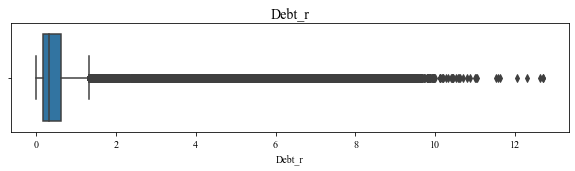

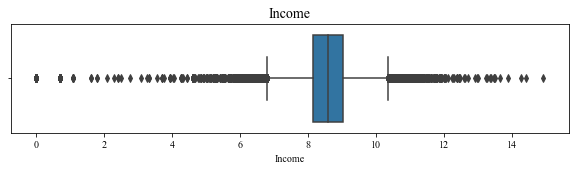

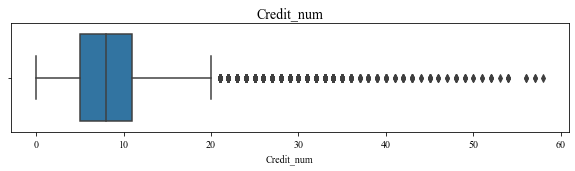

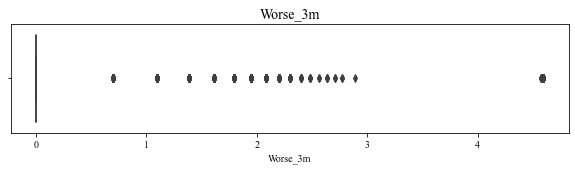

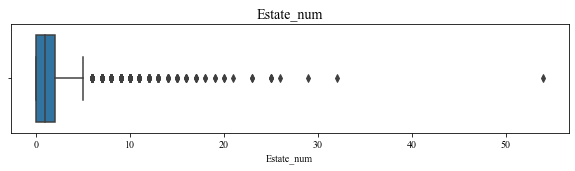

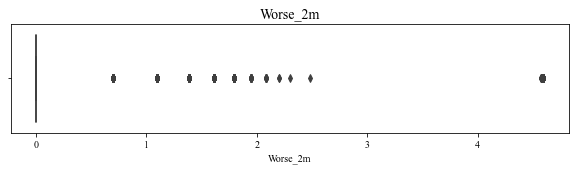

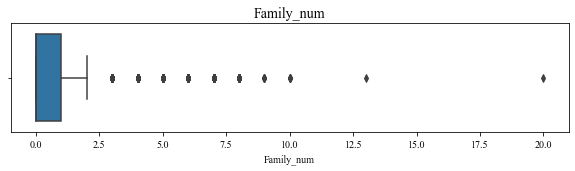

,count,mean,std,min,25%,50%,75%,max
Default,150000.0,0.067,0.250,0.0,0.000,0.000,0.000,1.000
Balance_r,150000.0,0.258,0.385,0.0,0.029,0.143,0.444,10.834
Age,150000.0,52.295,14.772,0.0,41.000,52.000,63.000,109.000
Worse_1m,150000.0,0.148,0.392,0.0,0.000,0.000,0.000,4.595
Debt_r,150000.0,1.525,2.627,0.0,0.161,0.312,0.625,12.706
Income,120269.0,8.411,1.333,0.0,8.132,8.594,9.018,14.917
Credit_num,150000.0,8.453,5.146,0.0,5.000,8.000,11.000,58.000
Worse_3m,150000.0,0.057,0.293,0.0,0.000,0.000,0.000,4.595
Estate_num,150000.0,1.018,1.130,0.0,0.000,1.000,2.000,54.000
Worse_2m,150000.0,0.048,0.265,0.0,0.000,0.000,0.000,4.595


In [92]:
# 得到对数变换后的data, 再次summary并画出箱型图
train_data1=train_data.copy()
train_data1[skew_index]=log_data
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data1, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)
train_data1.describe().round(3).T

如图所示, 经过变换后的outlier情况有所好转, 因此我们接受对数变换的结果, 对于其他的outlier, 我们用99%的缩尾

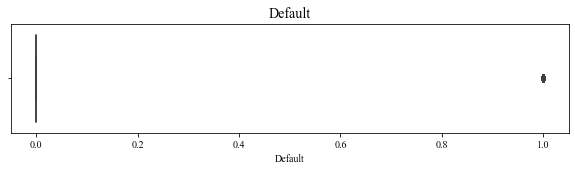

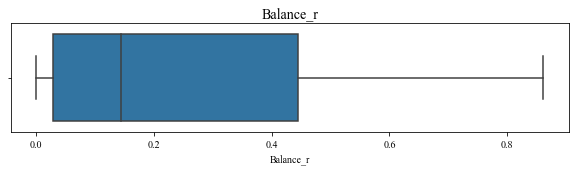

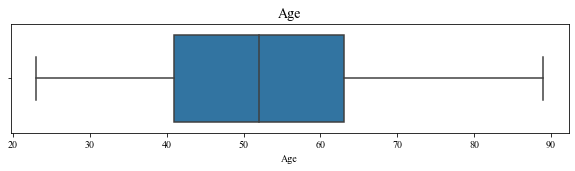

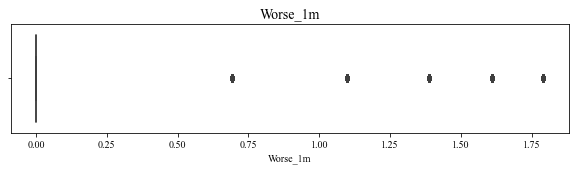

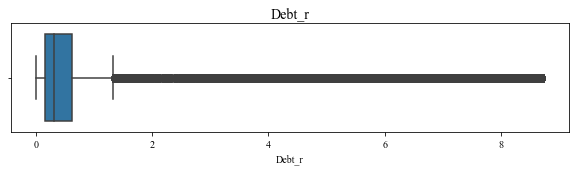

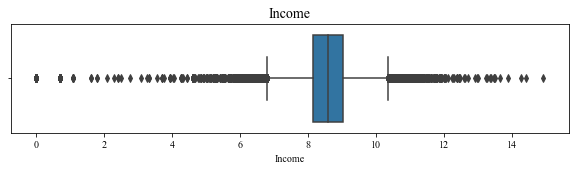

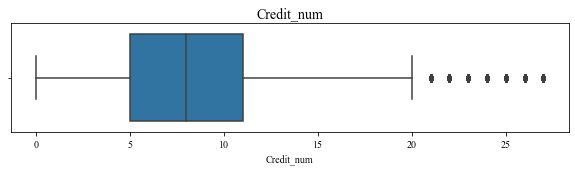

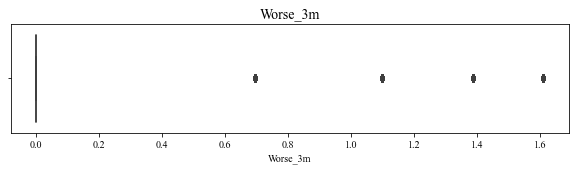

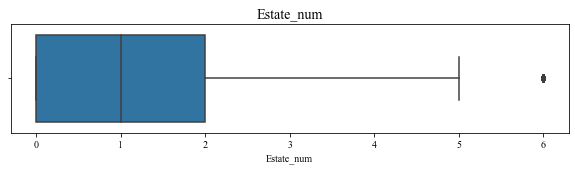

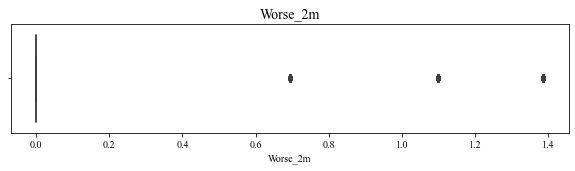

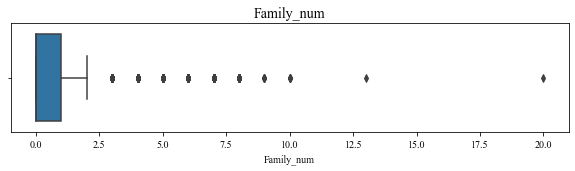

,count,mean,std,min,25%,50%,75%,max
Default,150000.0,0.067,0.250,0.0,0.000,0.000,0.000,1.000
Balance_r,150000.0,0.247,0.249,0.0,0.029,0.143,0.444,0.861
Age,150000.0,52.286,14.721,23.0,41.000,52.000,63.000,89.000
Worse_1m,150000.0,0.142,0.349,0.0,0.000,0.000,0.000,1.792
Debt_r,150000.0,1.523,2.622,0.0,0.161,0.312,0.625,8.730
Income,120269.0,8.411,1.333,0.0,8.132,8.594,9.018,14.917
Credit_num,150000.0,8.427,5.026,0.0,5.000,8.000,11.000,27.000
Worse_3m,150000.0,0.051,0.224,0.0,0.000,0.000,0.000,1.609
Estate_num,150000.0,1.008,1.043,0.0,0.000,1.000,2.000,6.000
Worse_2m,150000.0,0.042,0.188,0.0,0.000,0.000,0.000,1.386


In [93]:
# 进行99%的winsorize缩尾处理
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005],nan_policy="omit")
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data1, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)
train_data1.describe().round(3).T


我们不再继续处理离群值, 以防过度处理会降低分析的效度.